## Stock Prediction of Google stock with Recurrent Neural Network
Deep learning is very popular a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration. With the tradition simpler models like the Regressors we do not have a very good accuracy.

We will make a really simple LSTM with Keras to predict the stock price for Google.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

Using TensorFlow backend.
C:\Python\envs\ML Project\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Python\envs\ML Project\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Python\envs\ML Project\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Python\envs\ML Project\lib\site-packages\tensorflow\python\framework\dtype

## Reading data using parse date
As it is timeseries data so we have to read the data by parsing date means making data column as index.

In [2]:
df = pd.read_csv('google.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [3]:
##Viewing the shape of the data
df.shape

(3125, 12)

## Summary statistics of our data

In [13]:
df.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,3125.000000,3125.000000,3125.000000,3125.000000,3.125000e+03,3125.000000,3125.0,3125.000000,3125.000000,3125.000000,3125.000000,3.125000e+03
mean,560.171567,565.480031,554.309518,559.907342,8.404691e+06,0.181751,1.0,354.861790,358.112859,351.231911,354.691981,8.404691e+06
std,200.944961,201.563829,199.979903,200.813213,8.399679e+06,10.160186,0.0,195.252794,196.367956,193.820339,195.144724,8.399679e+06
min,99.090000,101.740000,95.960000,100.010000,5.211410e+05,0.000000,1.0,49.698414,51.027517,48.128568,50.159839,5.211410e+05
25%,445.250000,450.720000,438.560500,444.080000,3.209500e+06,0.000000,1.0,223.314350,226.057819,219.959243,222.727539,3.209500e+06
50%,548.490000,553.520000,543.670000,548.650000,5.620700e+06,0.000000,1.0,288.992091,291.399522,286.760201,289.578902,5.620700e+06
75%,667.490000,673.027500,659.240000,667.120000,1.107890e+07,0.000000,1.0,517.492450,520.810000,513.108918,517.372078,1.107890e+07
max,1226.800000,1228.880000,1218.600000,1220.170000,8.215110e+07,567.971668,1.0,838.500000,839.000000,829.520000,835.740000,8.215110e+07


In [15]:
##Checking for null values
df.isnull().values.any()

False

## Data Cleaning
Here we will be cleaning our data by dropping columns we do not need. The split ratio column has got the same values all through and as such may not be useful in making our prediction. The Ex-dividend column also has just the same values of zero all through and will be dropped.

In [19]:
df_cleaned = df.drop(['Ex-Dividend', 'Split Ratio'],axis=1)
df_cleaned.head()

,Open,High,Low,Close,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,52.542193,54.167209,52.100830,53.164113,9188600.0


We will also proceed to strip our feature names with spaces and special characters replacing them with underscores.

In [20]:
df_cleaned.columns.str.strip('.')
df_cleaned.columns = df_cleaned.columns.str.replace('[^A-Za-z\s]+', '_')
df_cleaned.columns = df_cleaned.columns.str.replace(' ', '')
df_cleaned

,Open,High,Low,Close,Volume,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,
2004-08-19,100.01,104.06,95.9600,100.335,44659000.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.5000,108.310,22834300.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.0500,109.400,18256100.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.5700,104.870,15247300.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.8800,106.000,9188600.0,52.542193,54.167209,52.100830,53.164113,9188600.0
...,...,...,...,...,...,...,...,...,...,...
2017-01-10,827.07,829.41,823.1400,826.010,1141799.0,827.070000,829.410000,823.140000,826.010000,1141799.0
2017-01-11,826.62,829.90,821.4700,829.860,1261666.0,826.620000,829.900000,821.470000,829.860000,1261666.0
2017-01-12,828.38,830.38,821.0100,829.530,1348274.0,828.380000,830.380000,821.010000,829.530000,1348274.0


## Data Exploration and preprocessing.

We seperate our feature data from our taret data which in this case is the Adj_close column and carry out correlation analysis. 

In [23]:
##Selecting our feature data
X=df_cleaned.drop(['Adj_Close'],axis=1)
X=X.drop(['Close'],axis=1)

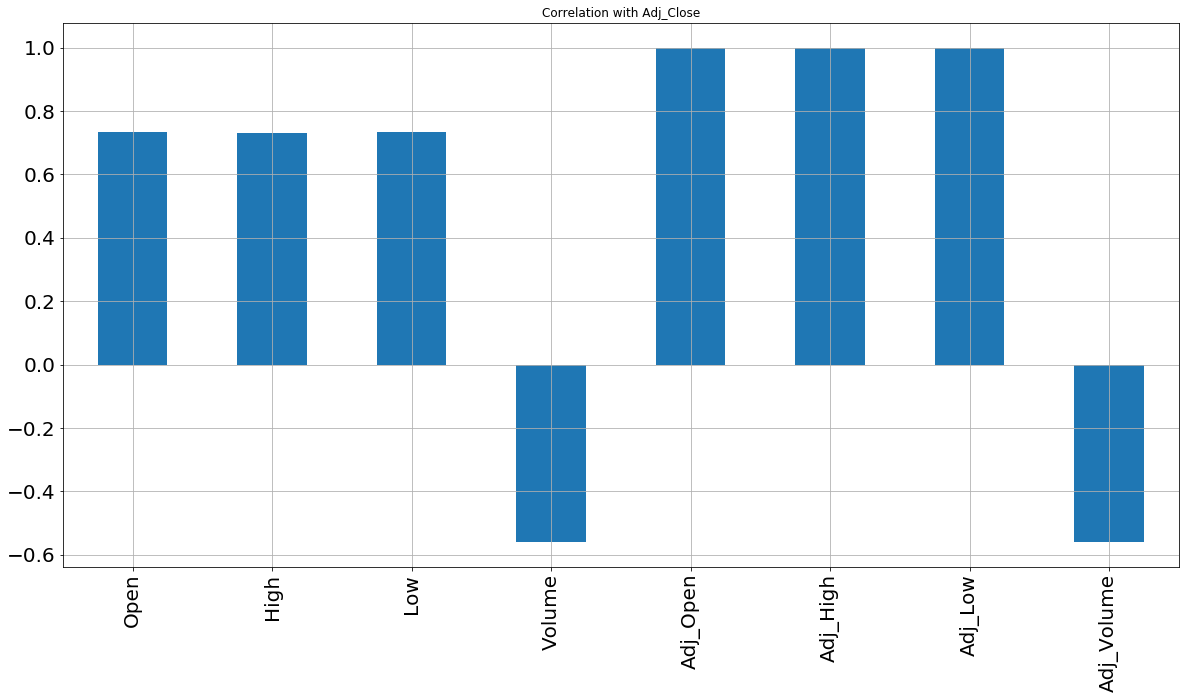

In [26]:
##Correlation Plot
X.corrwith(df_cleaned['Adj_Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Adj_Close", fontsize = 20,
        rot = 90, grid = True)

In [27]:
# Target column
test = df_cleaned
y = pd.DataFrame(test['Adj_Close'])
display(test.head())

,Open,High,Low,Close,Volume,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [30]:
feature_columns = ['Open', 'High', 'Low', 'Volume', 'Adj_Open', 'Adj_High', 'Adj_Volume']

## Scaling our data
We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. Having different features with widely different scales fed to your model will cause the network to weight the features not equally.

In [31]:
##Data was normalized unsing the MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume,Adj_Open,Adj_High,Adj_Volume
Date,,,,,,,
2004-08-19,0.000816,0.002058,0.000000,0.540707,0.000585,0.001477,0.540707
2004-08-20,0.001703,0.006512,0.004044,0.273345,0.001221,0.004672,0.273345
2004-08-23,0.010348,0.010416,0.011660,0.217260,0.007420,0.007473,0.217260
2004-08-24,0.010774,0.008748,0.006779,0.180401,0.007725,0.006276,0.180401
2004-08-25,0.005028,0.005554,0.007055,0.106180,0.003605,0.003985,0.106180


In [33]:
##Viweing the shape of our feature and target data
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', y.shape)

,Open,High,Low,Volume,Adj_Open,Adj_High,Adj_Volume
Date,,,,,,,
2004-08-19,0.000816,0.002058,0.000000,0.540707,0.000585,0.001477,0.540707
2004-08-20,0.001703,0.006512,0.004044,0.273345,0.001221,0.004672,0.273345
2004-08-23,0.010348,0.010416,0.011660,0.217260,0.007420,0.007473,0.217260
2004-08-24,0.010774,0.008748,0.006779,0.180401,0.007725,0.006276,0.180401
2004-08-25,0.005028,0.005554,0.007055,0.106180,0.003605,0.003985,0.106180


Shape of features :  (3125, 7)
Shape of target :  (3125, 1)


In [34]:
# Shift target array because we want to predict the n + 1 day value
y = y.shift(-1)
validation_y = y[-90:-1]
y = y[:-90]


In [35]:
# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

,Open,High,Low,Volume,Adj_Open,Adj_High,Adj_Volume
Date,,,,,,,
2017-01-09,0.644918,0.646495,0.646387,0.010829,0.984622,0.989124,0.010829
2017-01-10,0.645538,0.645590,0.647741,0.007603,0.985510,0.987830,0.007603
2017-01-11,0.645139,0.646024,0.646253,0.009072,0.984939,0.988451,0.009072
2017-01-12,0.646700,0.646450,0.645844,0.010133,0.987170,0.989061,0.010133
2017-01-13,0.649023,0.650239,0.653424,0.008993,0.990492,0.994480,0.008993


,Adj_Close
Date,
2017-01-09,826.01
2017-01-10,829.86
2017-01-11,829.53
2017-01-12,830.94
2017-01-13,827.20


print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', y.shape)
display(y.tail())

## Train test Split using Timeseriessplit
Since our problem is a time series problem, we will be splitting our data into training and test sets using the Timeseriessplit

In [38]:
##Splitting our data into 10 splits unsing TimeSeriesSplit.
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [40]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2760, 7)
(275, 7)
(2760,)
(275,)


In [42]:
##Function to validate results which we will get from the model we will be applying
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

## Processing our data to apply the LSTM model


In [43]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Model building: LSTM

In [51]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
2760/2760 [==============================] - 1s 461us/step - loss: 109676.3196
Epoch 2/200
2760/2760 [==============================] - 1s 296us/step - loss: 105541.7521
Epoch 3/200
2760/2760 [==============================] - 1s 317us/step - loss: 99436.4073
Epoch 4/200
2760/2760 [==============================] - 1s 312us/step - loss: 91959.8189
Epoch 5/200
2760/2760 [==============================] - 1s 305us/step - loss: 83608.1012
Epoch 6/200
2760/2760 [==============================] - 1s 301us/step - loss: 74774.3688
Epoch 7/200
2760/2760 [==============================] - 1s 294us/step - loss: 65797.7179
Epoch 8/200
2760/2760 [==============================] - 1s 299us/step - loss: 56972.7130
Epoch 9/200
2760/2760 [==============================] - 1s 351us/step - loss: 48549.9295
Epoch 10/200
2760/2760 [==============================] - 1s 329us/step - loss: 40734.9494
Epoch 11/200
2760/2760 [==============================] - 1s 295us/step - loss: 33687.0586
Epoch 

## Evaluation of Model
Here we used the R squared as the evaluation metric for our model which gave us an accuracy of 99.8% on the training set and 91.8% on the test set which did better than previous models applied.

In [53]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.998
The R2 score on the Test set is:	0.918


## Predictions made by LSTM.

In [54]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

275/275 [==============================] - 0s 1ms/step


In [55]:
print('LSTM: %f'%score_lstm)

LSTM: 164.101865


In [56]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

## Visualizing our LSTM Predictions

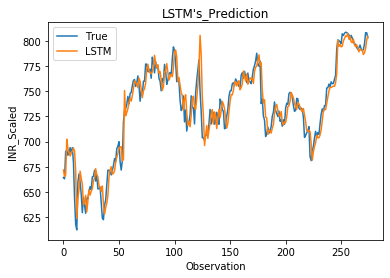

In [57]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## Converting Prediction data 
Here our prediction results will be written into a csv file in order to view in real time how our model has performed in the predicting our Adj_Close.

In [59]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift.xlsx')

## Conclusion
Due to the volatility of the stock market, It is difficult to get prediction accuracies which are high with the simpler models. However with recurrent neural networks paticularly the LSTM which we have applied, we can come closer to 100% as seen in this project. We could improve the accuracy of our model by tuning parameters like the epochs and the activation function.